# Generating Data

#### Importing python libraries and defining two functions with different flavors for calculating Fbeta score

In [28]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import random

random.seed(42)

# Import supplementary visualizations code visuals.py
import vpython as vs

# Pretty display for notebooks
%matplotlib inline

def f_beta_score(y_clean,y_dirty,y_pred,beta=0.5):
    total_positives=len(np.where(y_dirty-y_pred!=0)[0])
    true_positives=len(np.intersect1d(np.where(y_dirty-y_clean!=0)[0],np.where(y_dirty-y_pred!=0)[0]))
    false_positives=total_positives-true_positives
    false_negatives=len(np.where(y_dirty-y_clean!=0)[0])-true_positives
    precision=true_positives/(true_positives+false_positives)
    recall=true_positives/(true_positives+false_negatives)
    return (1+beta**2)*(precision*recall)/((beta**2)*precision+recall)

def f_beta_score1(actual_noise_labels,predicted_noise_labels,beta=0.5):
    total_positives=len(predicted_noise_labels)
    true_positives=len(np.intersect1d(actual_noise_labels,predicted_noise_labels))
    false_positives=total_positives-true_positives
    false_negatives=len(actual_noise_labels)-true_positives
    precision=true_positives/(true_positives+false_positives)
    recall=true_positives/(true_positives+false_negatives)
    return (1+beta**2)*(precision*recall)/((beta**2)*precision+recall)

#### Generating SNR data and corrupting 0.5% samples with Gaussian noise

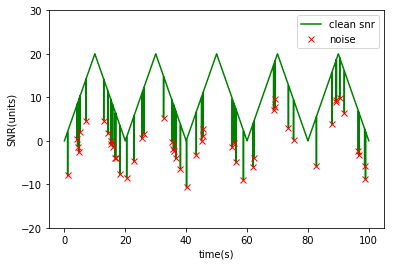

In [29]:
snr=[i/100 for i in range(0,2000,2)]
snr+=[i/100 for i in range(2000,0,-2)]
time=[i/100 for i in range(0,10000)]
time=np.array(time)

snr=snr*5
snr=np.array(snr)
snr_clean=np.copy(snr)
snr_noise_index=[random.randint(0,10001) for i in range(50)]

for i in snr_noise_index:
    snr[i]+=np.random.normal(-10,1,1)[0]

plt.plot(time,snr,'-g',label='clean snr')
plt.plot(time[snr_noise_index],snr[snr_noise_index],'xr',label='noise')
plt.legend(loc='upper right')
plt.ylim(-20,30)
plt.xlabel('time(s)')
plt.ylabel('SNR(units)')
plt.show()

#### Generating CQI data and corrupting 0.5% samples with randint noise

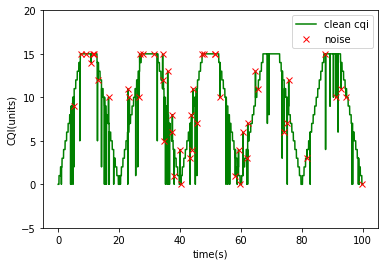

In [30]:
snr2cqi=[-100,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,100]
cqi_clean=[]
cqi=[]

from random import randint

for i in snr:
    for j in range(1,len(snr2cqi)):
        if i<=snr2cqi[j]+0.5 and i>snr2cqi[j-1]+0.5:
            cqi_clean.append(min(snr2cqi[j],15))
            break

cqi_noise_index=[randint(0,10001) for i in range(50)]
cqi_clean=np.array(cqi_clean)
cqi=np.copy(cqi_clean)

for i in cqi_noise_index:
    cqi[i]+=randint(-5,5)
    cqi[i]=max(0,cqi[i])
    cqi[i]=min(15,cqi[i])
            
plt.plot(time,cqi,'-g',label='clean cqi')
plt.plot(time[cqi_noise_index],cqi[cqi_noise_index],'xr',label='noise')
plt.legend(loc='upper right')
plt.ylim(-5,20)
plt.xlabel('time(s)')
plt.ylabel('CQI(units)')
plt.show()


#### Generating MCS data and corrupting 0.5% samples with randint noise

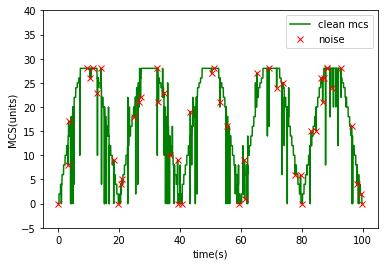

In [31]:
mcs2cqi=[0,2,4,6,8,10,12,14,16,18,20,22,24,25,26,28]
clean_mcs_from_clean_cqi=[]
mcs_clean=[]
mcs=[]
for i in cqi_clean:
    clean_mcs_from_clean_cqi.append(mcs2cqi[int(i)])

clean_mcs_from_clean_cqi=np.array(clean_mcs_from_clean_cqi)
    
for i in cqi:
    mcs_clean.append(mcs2cqi[int(i)])

mcs_clean=np.array(mcs_clean)
mcs=np.copy(mcs_clean)

mcs_noise_index=[randint(0,10001) for i in range(50)]

for i in mcs_noise_index:
    mcs[i]+=randint(-5,5)
    mcs[i]=max(0,mcs[i])
    mcs[i]=min(28,mcs[i])    

plt.plot(time,mcs,'-g',label='clean mcs')
plt.plot(time[mcs_noise_index],mcs[mcs_noise_index],'xr',label='noise')
plt.legend(loc='upper right')
plt.ylim(-5,40)
plt.xlabel('time(s)')
plt.ylabel('MCS(units)')
plt.show()

#### Generating TBS data

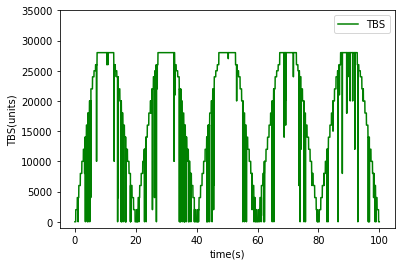

In [32]:
tbs=[]
for i in range(len(mcs)):
    if mcs[i]<=clean_mcs_from_clean_cqi[i]:
        tbs.append(mcs[i]*1000)
    else:
        tbs.append(0)
tbs=np.array(tbs)

plt.plot(time,tbs,'-g',label='TBS')
plt.legend(loc='upper right')
plt.ylim(-1000,35000)
plt.xlabel('time(s)')
plt.ylabel('TBS(units)')
plt.show()

# Implementation and Results

#### Using DBSCAN to find noise samples in SNR

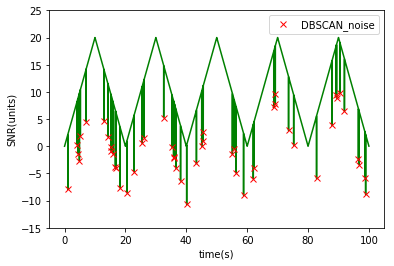

F0.5 score= 1.0


In [33]:
from sklearn import cluster

db=cluster.DBSCAN(eps=0.50,min_samples=5)
snr=np.array(snr).reshape(-1,1)
time=np.array(time).reshape(-1,1)
X=np.concatenate((time,snr),axis=1)
db.fit(X)
snr_labels=np.array(db.labels_)
snr_noise_labels_pred=np.where(snr_labels<0)[0]
plt.plot(time,snr,'g')
plt.plot(time[snr_noise_labels_pred],snr[snr_noise_labels_pred],'xr',label='DBSCAN_noise')
plt.legend(loc='upper right')
plt.ylim(-15,25)
plt.xlabel('time(s)')
plt.ylabel('SNR(units)')
plt.show()
print("F0.5 score=",f_beta_score1(snr_noise_index,snr_noise_labels_pred))

#### Performance of Benchmark models for finding jumps in SNR

In [34]:
from sklearn.cluster import KMeans
from sklearn import mixture

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans_labels=kmeans.labels_
clust = cluster.AgglomerativeClustering(n_clusters=2)
clust_labels=clust.fit_predict(X)
gmm=mixture.GaussianMixture(n_components=2)
gmm_labels=gmm.fit_predict(X)



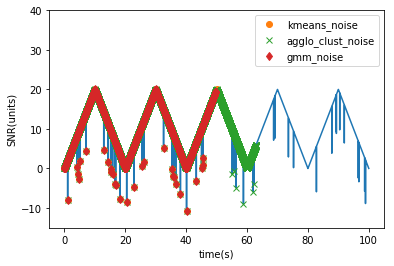

In [35]:
plt.plot(time,snr)
plt.plot(time[np.where(kmeans_labels==0)[0]],snr[np.where(kmeans_labels==0)[0]],'o',label='kmeans_noise')
plt.plot(time[np.where(clust_labels==0)[0]],snr[np.where(clust_labels==0)[0]],'x',label='agglo_clust_noise')
plt.plot(time[np.where(gmm_labels==0)[0]],snr[np.where(gmm_labels==0)[0]],'d',label='gmm_noise')
plt.legend(loc='upper right')
plt.ylim(-15,40)
plt.xlabel('time(s)')
plt.ylabel('SNR(units)')
plt.show()

#### Using neural network to predict CQI error

In [36]:
from keras.utils import np_utils

# Set random seed
np.random.seed(42)

# Our data
X = snr
y = cqi
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.regularizers import l1,l2
from keras.callbacks import ModelCheckpoint

y = np_utils.to_categorical(y)

model0 = Sequential()
model0.add(Dense(32, input_dim=1))
model0.add(Activation("tanh"))
model0.add(Dense(32))
model0.add(Activation("tanh"))
model0.add(Dense(16))
model0.add(Activation("softmax"))
print (model0.summary())

model0.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='weights.best.snr2cqi.hdf5', 
                               verbose=0, save_best_only=True)

# Fitting the model
history = model0.fit(X, y, epochs=200, verbose=0,validation_split=0.2,callbacks=[checkpointer],shuffle=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                64        
_________________________________________________________________
activation_7 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
activation_9 (Activation)    (None, 16)                0         
Total params: 1,648
Trainable params: 1,648
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
model0.load_weights('weights.best.snr2cqi.hdf5')

score = model0.evaluate(X, y)
print("\nAccuracy: {0:.2f}".format(score[-1]))

10000/10000 [==============================] - 0s 19us/step

Accuracy: 0.98


In [38]:

X=snr
y=cqi_clean
y_pred=np.argmax(model0.predict(X),axis=1)
print ("\nF0.5 score: {0:.2f}".format(f_beta_score(cqi_clean,cqi,y_pred)))
cqi_noise_labels_pred_neural_network=np.where(y_pred-)[0]



F0.5 score: 0.26


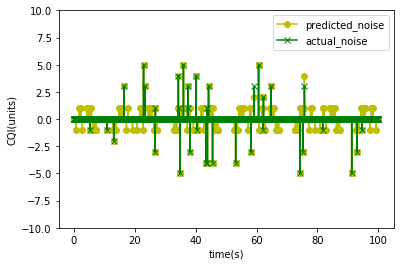

In [39]:
plt.plot(time,cqi-y_pred,'-oy',label='predicted_noise')
plt.plot(time,cqi-cqi_clean,'-xg',label='actual_noise')
plt.legend(loc='upper right')
plt.ylim(-10,10)
plt.xlabel('time(s)')
plt.ylabel('CQI(units)')
plt.show()

#### Using SVC to predict CQI error

In [40]:
X=snr
y=cqi
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

clf_cqi=OneVsRestClassifier(SVC(gamma="auto",random_state=0)).fit(X_train, y_train)
clf_cqi_pred=clf_cqi.predict(X_test)

from sklearn.linear_model import LinearRegression
regr_cqi=LinearRegression()
regr_cqi.fit(X_train, y_train)
regr_cqi_pred=np.clip(np.round(regr_cqi.predict(X_test)),0,15)

from sklearn.metrics import accuracy_score

print ("\nAccuracy score (SVC): {0:.2f}".format(accuracy_score(y_test,clf_cqi_pred)))
print ("\nAccuracy score (benchmark): {0:.2f}".format(accuracy_score(y_test,regr_cqi_pred)))

clf_cqi_pred=clf_cqi.predict(X)
regr_cqi_pred=np.clip(np.round(regr_cqi.predict(X)),0,15)
cqi_noise_labels_pred=np.where(clf_cqi_pred-cqi!=0)[0]

print ("\nF0.5 score (SVC): {0:.2f}".format(f_beta_score(cqi_clean,cqi,clf_cqi_pred)))
print ("\nF0.5 score (benchmark): {0:.2f}".format(f_beta_score(cqi_clean,cqi,regr_cqi_pred)))



Accuracy score (SVC): 0.99

Accuracy score (benchmark): 0.53

F0.5 score (SVC): 0.60

F0.5 score (benchmark): 0.01


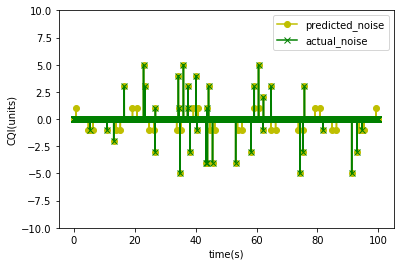

In [106]:
plt.plot(time,cqi-clf_cqi_pred,'-oy',label='predicted_noise')
plt.plot(time,cqi-cqi_clean,'-xg',label='actual_noise')
plt.legend(loc='upper right')
plt.ylim(-10,10)
plt.xlabel('time(s)')
plt.ylabel('CQI(units)')
plt.show()

#### Using SVC to predict MCS error

In [42]:
X=cqi.reshape(-1,1)
y=mcs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

clf_mcs=OneVsRestClassifier(SVC(gamma="auto",random_state=0)).fit(X_train, y_train)
clf_mcs_pred=clf_mcs.predict(X_test)

regr_mcs=LinearRegression()
regr_mcs.fit(X_train, y_train)
regr_mcs_pred=np.clip(np.round(regr_mcs.predict(X_test)),0,28)

print ("\nAccuracy score (SVC): {0:.2f}".format(accuracy_score(y_test,clf_mcs_pred)))
print ("\nAccuracy score (benchmark): {0:.2f}".format(accuracy_score(y_test,regr_mcs_pred)))

clf_mcs_pred=clf_mcs.predict(X)
regr_mcs_pred=np.clip(np.round(regr_mcs.predict(X)),0,15)

mcs_noise_labels_pred=np.where(clf_mcs_pred-mcs!=0)[0]

print ("\nF0.5 score (SVC): {0:.2f}".format(f_beta_score(mcs_clean,mcs,clf_mcs_pred)))
print ("\nF0.5 score (benchmark): {0:.2f}".format(f_beta_score(mcs_clean,mcs,regr_mcs_pred)))


Accuracy score (SVC): 1.00

Accuracy score (benchmark): 0.67

F0.5 score (SVC): 1.00

F0.5 score (benchmark): 0.01


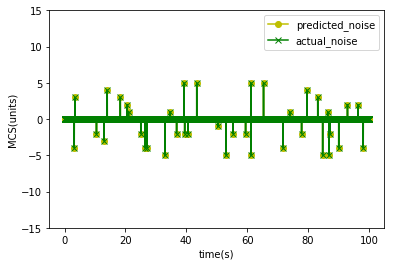

In [43]:
plt.plot(time,mcs-clf_mcs_pred,'-oy',label='predicted_noise')
plt.plot(time,mcs-mcs_clean,'-xg',label='actual_noise')
plt.legend(loc='upper right')
plt.ylim(-15,15)
plt.xlabel('time(s)')
plt.ylabel('MCS(units)')
plt.show()

#### Predicting CQI and MCS using the SVC models

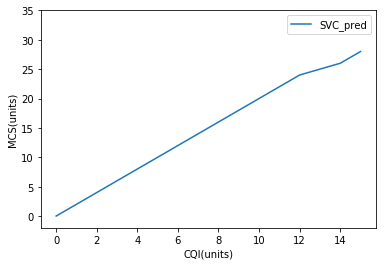

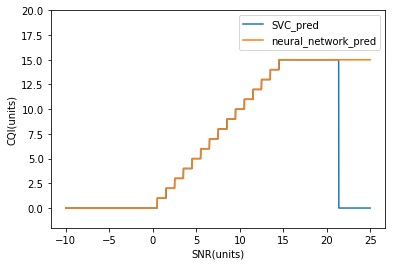

In [44]:
CQI_values=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
CQI_values=np.array(CQI_values).reshape(-1,1)
MCS_SVC_pred_values=clf_mcs.predict(CQI_values)
plt.plot(CQI_values,MCS_SVC_pred_values,label='SVC_pred')
plt.legend(loc='upper right')
plt.ylim(-2,35)
plt.xlabel('CQI(units)')
plt.ylabel('MCS(units)')
plt.show()
SNR_values=[i/100 for i in range(-1000,2500,2)]
SNR_values=np.array(SNR_values).reshape(-1,1)
CQI_SVC_pred_values=clf_cqi.predict(SNR_values)
CQI_NN_pred_values=np.argmax(model0.predict(SNR_values),axis=1)
plt.plot(SNR_values,CQI_SVC_pred_values,label='SVC_pred')
plt.plot(SNR_values,CQI_NN_pred_values,label='neural_network_pred')
plt.legend(loc='upper right')
plt.ylim(-2,20)
plt.xlabel('SNR(units)')
plt.ylabel('CQI(units)')
plt.show()


#### Analyzing the performance of the above generated model on classifying errors in TBS

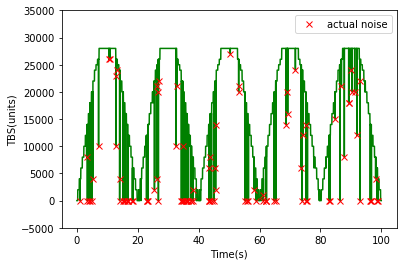

In [54]:
db=cluster.DBSCAN(eps=0.50,min_samples=5)
tbs=np.array(tbs).reshape(-1,1)
time=np.array(time).reshape(-1,1)
X_tbs=np.concatenate((time,tbs),axis=1)
db.fit(X_tbs)
tbs_labels=np.array(db.labels_)
tbs_noise_labels=np.where(tbs_labels<0)[0]
plt.plot(time,tbs,'g')
plt.plot(time[tbs_noise_labels],tbs[tbs_noise_labels],'xr',label='actual noise')
plt.legend(loc='upper right')
plt.ylim(-5000,35000)
plt.xlabel('Time(s)')
plt.ylabel('TBS(units)')
plt.show()

#### F0.5 score for the entire end-to-end solution

In [97]:
tbs_noise_labels_pred=np.concatenate((snr_noise_labels_pred,cqi_noise_labels_pred,mcs_noise_labels_pred),axis=0)
tbs_noise_labels_pred=np.unique(tbs_noise_labels_pred)
print ("\nF0.5 score: {0:.2f}".format(f_beta_score1(tbs_noise_labels,tbs_noise_labels_pred)))


F0.5 score: 0.71


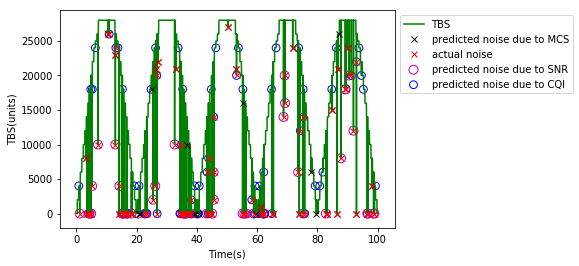

In [93]:
plt.plot(time,tbs,'g',label='TBS')
#plt.plot(time[snr_noise_labels_pred],tbs[snr_noise_labels_pred],'db',label='predicted noise due to SNR')
plt.scatter(time[snr_noise_labels_pred],tbs[snr_noise_labels_pred],s=80, facecolors='none', edgecolors='m',label='predicted noise due to SNR')
plt.scatter(time[cqi_noise_labels_pred],tbs[cqi_noise_labels_pred],s=60, facecolors='none', edgecolors='b',label='predicted noise due to CQI')
plt.plot(time[mcs_noise_labels_pred],tbs[mcs_noise_labels_pred],'xk',label='predicted noise due to MCS')
plt.plot(time[tbs_noise_labels],tbs[tbs_noise_labels],'xr',label='actual noise')
plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1)
plt.xlabel('Time(s)')
plt.ylabel('TBS(units)')
plt.show()

# Improvements

#### Increasing the threshold for CQI error from 0 to 1 and analyzing performance of SVC model

In [99]:
cqi_noise_labels_pred=np.where(abs(clf_cqi_pred-cqi)>1)[0]
cqi_noise_labels_actual=np.where(cqi_clean-cqi!=0)[0]
print ("\nF0.5 score (SVC): {0:.2f}".format(f_beta_score1(cqi_noise_labels_actual,cqi_noise_labels_pred)))


F0.5 score (SVC): 0.93


In [108]:
tbs_noise_labels_pred=np.concatenate((snr_noise_labels_pred,cqi_noise_labels_pred,mcs_noise_labels_pred),axis=0)
tbs_noise_labels_pred=np.unique(tbs_noise_labels_pred)
print ("\nF0.5 score (end-to-end): {0:.2f}".format(f_beta_score1(tbs_noise_labels,tbs_noise_labels_pred)))


F0.5 score (end-to-end): 0.87


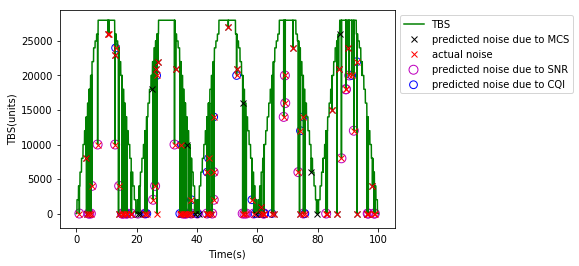

In [101]:
plt.plot(time,tbs,'g',label='TBS')
#plt.plot(time[snr_noise_labels_pred],tbs[snr_noise_labels_pred],'db',label='predicted noise due to SNR')
plt.scatter(time[snr_noise_labels_pred],tbs[snr_noise_labels_pred],s=80, facecolors='none', edgecolors='m',label='predicted noise due to SNR')
plt.scatter(time[cqi_noise_labels_pred],tbs[cqi_noise_labels_pred],s=60, facecolors='none', edgecolors='b',label='predicted noise due to CQI')
plt.plot(time[mcs_noise_labels_pred],tbs[mcs_noise_labels_pred],'xk',label='predicted noise due to MCS')
plt.plot(time[tbs_noise_labels],tbs[tbs_noise_labels],'xr',label='actual noise')
plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1)
plt.xlabel('Time(s)')
plt.ylabel('TBS(units)')
plt.show()

#### Increasing the threshold for CQI error from 0 to 1 and analyzing performance of Neural Network model

In [104]:
X=snr
y=cqi_clean
y_pred=np.argmax(model0.predict(X),axis=1)
cqi_noise_labels_pred_neural_network=np.where(abs(y_pred-cqi)>1)[0]
print ("\nF0.5 score: {0:.2f}".format(f_beta_score1(cqi_noise_labels_actual,cqi_noise_labels_pred_neural_network)))


F0.5 score: 0.93
